In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
from scipy import signal
import os
import pytz
import time
import re

Parameters

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

Aperture

In [51]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2)
ap_inner = (ar <= 1.5/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

Directory Paths

In [52]:
dome_seeing = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_1.35.6_poldm_phase.fits"
clean_seeing = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
save_path = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Results/temp_power_spec/"
dstr = time.strftime('%Y%m%d')

Process Image

In [54]:
def process_phase(filepath):

    hdulist = fits.open(filepath,memmap=True)
    phase = hdulist[0].data.astype('float')
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 

    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    return c_phase

In [64]:
y1_2D = process_phase(dome_seeing)
y2_2D = process_phase(clean_seeing)

y1_1D = np.mean(y1_2D,axis=(1,2))
y2_1D = np.mean(y2_2D,axis=(1,2))

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Temp power spec

In [58]:
def temp_power_spec(Y,sample_spacing):
    
    n = len(Y)
    dT = sample_spacing

    w = signal.blackman(n)
    P = np.fft.rfft(Y*w)
    norm = 2.0/n
    P = P * norm

    P2 = np.square(np.abs(P))
    k = np.fft.rfftfreq(n,dT)
    
    return k,P2

In [65]:
k1, y1_psd = temp_power_spec(y1_1D,.001)
k2, y2_psd = temp_power_spec(y2_1D,.001)

Smoothing

In [66]:
y1_smoothed = 10**signal.savgol_filter(np.log10(y1_psd), 101, 5) 
y2_smoothed = 10**signal.savgol_filter(np.log10(y2_psd), 101, 5) 

Linear fit

In [79]:
def linear_fit(k,Y,sampling_frequency):
    
    n = len(Y)
    dT = sampling_frequency
   
    par = np.polyfit(np.log10(k[(k>1./(n*dT)) & (k<2000.)]), np.log10(Y[(k>1./(n*dT)) & (k<2000.)]), 1)
    slope = par[0]
    intercept = par[1]
    
    print(slope,intercept)

    return slope,intercept

In [80]:
m1, int1 = linear_fit(k1,y1_smoothed,.001)
m2, int2 = linear_fit(k2,y2_smoothed,.001)

-1.69142185584 -5.38185598572
-3.08744002075 -2.97129492504


Plot power spec

<IPython.core.display.Javascript object>


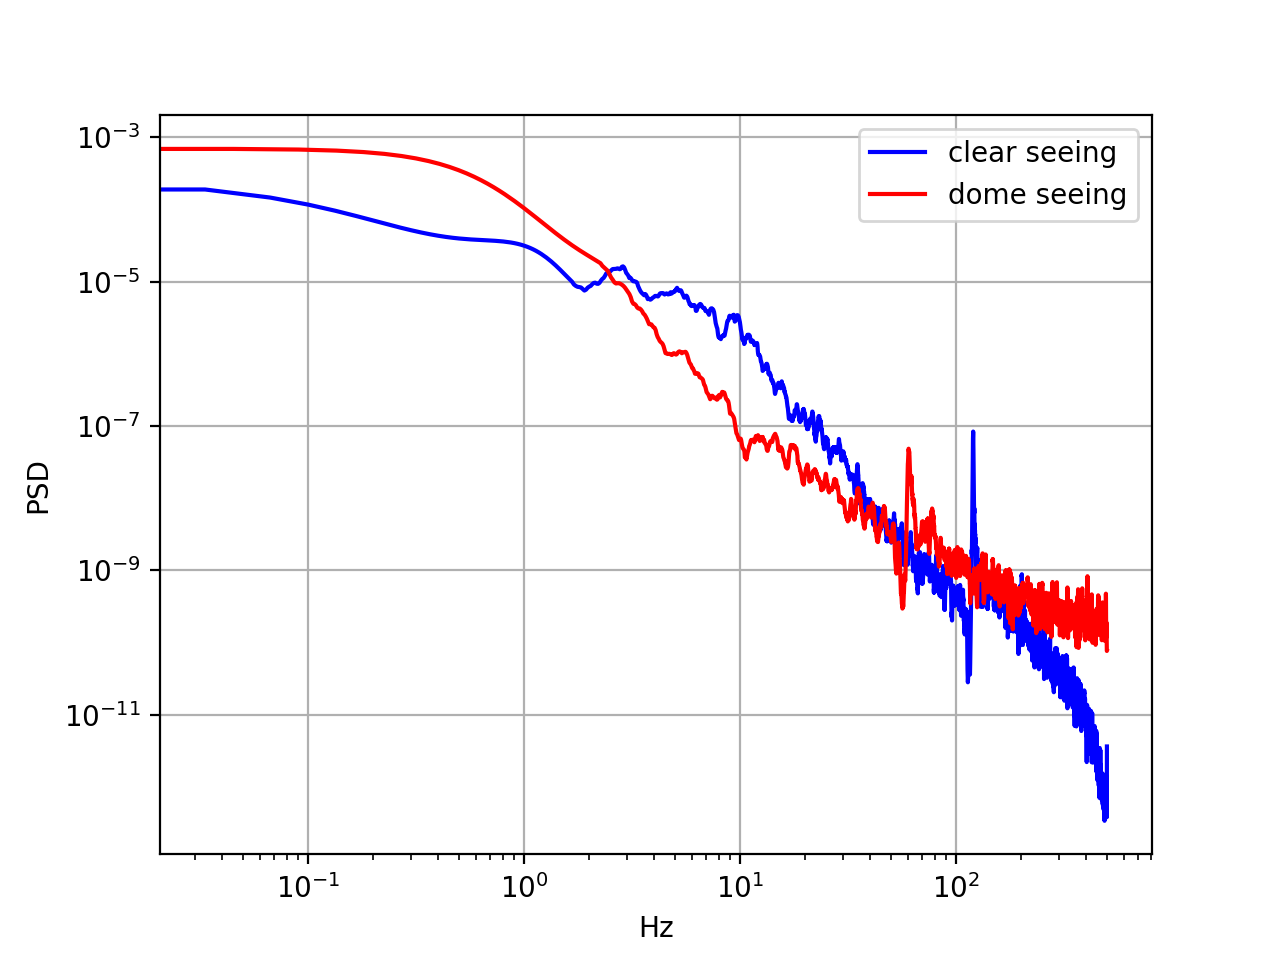

In [86]:
%matplotlib notebook

plt.figure(1)
#plt.loglog(k2,y2_psd,'b')
#plt.loglog(k1,y1_psd,'r')

plt.loglog(k2,y2_smoothed,'b',label = 'clear seeing')
plt.loglog(k1,y1_smoothed,'r',label = 'dome seeing')

#plt.loglog(k1,(10**int1)*k1**m1, 'k:',lw=3)
#plt.loglog(k2,(10**int2)*k2**m2,'k:',lw=3)

plt.grid(axis='both')
plt.xlabel('Hz')
plt.ylabel('PSD')
#plt.vlines(colors='grey',x=)
plt.legend()


